In [13]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

#from stratx.partdep import *

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1
            
# times are in 830 to mean 08:30, convert to two columns, hour and min
def cvt_time(df, colname):
    df[f'{colname}_HOUR'] = df[colname] / 100
    df[f'{colname}_MIN']  = df[colname] - df[f'{colname}_HOUR'] * 100
    df[f'{colname}_HOUR'] = df[f'{colname}_HOUR'].astype(int)
    df[f'{colname}_MIN']  = df[f'{colname}_MIN'].astype(int)

def load_flights(n):
    """
    Download from https://www.kaggle.com/usdot/flight-delays/download and save
    flight-delays.zip; unzip to convenient data dir.  Save time by storing as
    feather.  5.8M records.
    """
    df_flights = pd.read_feather("/Users/parrt/data/flight-delays/flights.feather")

    df_flights['dayofyear'] = pd.to_datetime(
        df_flights[['YEAR', 'MONTH', 'DAY']]).dt.dayofyear
    df_flights = df_flights[
        (df_flights['CANCELLED'] == 0) & (df_flights['DIVERTED'] == 0)]

    cvt_time(df_flights, 'SCHEDULED_DEPARTURE')
    cvt_time(df_flights, 'SCHEDULED_ARRIVAL')
    cvt_time(df_flights, 'DEPARTURE_TIME')

    features = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'dayofyear',
                'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                'SCHEDULED_DEPARTURE',
#                'SCHEDULED_DEPARTURE_HOUR', 'SCHEDULED_DEPARTURE_MIN',
                'SCHEDULED_ARRIVAL',
#                'SCHEDULED_ARRIVAL_HOUR',   'SCHEDULED_ARRIVAL_MIN',
                'DEPARTURE_TIME',
#                'DEPARTURE_TIME_HOUR',      'DEPARTURE_TIME_MIN',
                'FLIGHT_NUMBER', 'TAIL_NUMBER',
                'AIR_TIME', 'DISTANCE',
                'TAXI_IN', 'TAXI_OUT',
                'SCHEDULED_TIME',
                'ARRIVAL_DELAY']  # target

    df_flights = df_flights[features]
    print(df_flights.shape)
    df_flights = df_flights.dropna()  # ignore missing stuff for ease and reduce size
    df_flights = df_flights.sample(n)
    df_string_to_cat(df_flights)
    df_cat_to_catcode(df_flights)

    X, y = df_flights.drop('ARRIVAL_DELAY', axis=1), df_flights['ARRIVAL_DELAY']

    return X, y, df_flights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
X, y, df_flights = load_flights(n=20_000) # 50_000 gets about R^2 .85

(5714008, 19)


In [15]:
df_flights.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,dayofyear,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,FLIGHT_NUMBER,TAIL_NUMBER,AIR_TIME,DISTANCE,TAXI_IN,TAXI_OUT,SCHEDULED_TIME,ARRIVAL_DELAY
3196683,2015,7,19,7,200,1,248,349,1355,1517,1400.0,2479,2210,153.0,1235,21.0,18.0,202.0,-5.0
5292532,2015,11,28,6,332,4,254,265,835,1037,838.0,1844,3957,164.0,986,5.0,21.0,182.0,11.0
1225843,2015,3,21,6,80,11,331,285,605,1358,607.0,1021,3106,250.0,2227,6.0,21.0,293.0,-14.0
2431730,2015,6,3,3,154,14,303,285,1725,2155,1733.0,3765,4101,192.0,1411,8.0,12.0,210.0,10.0
188591,2015,1,13,2,13,5,187,407,905,1040,903.0,5499,3685,70.0,508,4.0,26.0,95.0,3.0


In [126]:
np.unique(X[np.isin(X['DAY'],[6,20])]['DAY'], return_counts=True)

(array([ 6, 20]), array([622, 653]))

In [79]:
rf = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [80]:
rf.oob_score_

0.8047739967968778

## Examine categorical FLIGHT_NUMBER

In [16]:
X, y, df_flights = load_flights(n=10_000)

In [18]:
#df_flights = df_flights[df_flights['FLIGHT_NUMBER']<500] # look at subset of flight numbers
X, y = df_flights.drop('ARRIVAL_DELAY', axis=1), df_flights['ARRIVAL_DELAY']

### Marginal plot

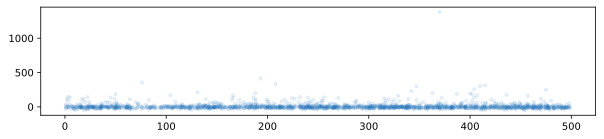

In [19]:
plt.figure(figsize=(10,2))
plt.scatter(df_flights['FLIGHT_NUMBER'], df_flights['ARRIVAL_DELAY'], alpha=.1, s=10)
plt.show()

### PDP

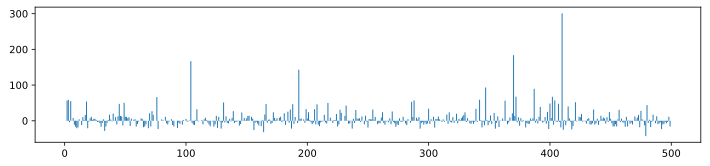

In [20]:
df = df_flights.groupby('FLIGHT_NUMBER').mean()['ARRIVAL_DELAY'].reset_index()
plt.figure(figsize=(12,2.5))
plt.bar(df['FLIGHT_NUMBER'], df['ARRIVAL_DELAY'])
plt.show()

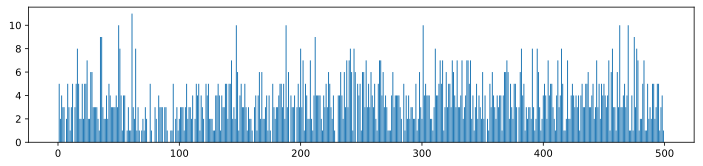

In [21]:
df = df_flights.groupby('FLIGHT_NUMBER').count()['ARRIVAL_DELAY'].reset_index()
plt.figure(figsize=(12,2.5))
plt.bar(df['FLIGHT_NUMBER'], df['ARRIVAL_DELAY'])
plt.show()

In [ ]:
print(df_flights.groupby("FLIGHT_NUMBER").count_values())